# Observables and other functionals

In this notebook we will learn how to

* compute the $L^2$ norm (`l2norm`)
* normalize a function (`normalize`)
* compute the $L^2$ inner product (`l2inner`)
* Using differential operators to create observables 

[Back to tensorgrid quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import time 

import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, sin, cos, abs, real, imag, pi, max, diag
from torch.linalg import norm, matrix_exp

### The `l2norm` function


We scale the potential down, so that we can see it together with the initial condition `u`. Note that the wavefunction in Quantum Mechanics should be normalised. We do this in the code

```Python
    u = u/ex.l2norm(u, xrange)
```

The function `l2norm` is the `expsolve.fourier` equivalent of the `norm` function in `numpy.linalg`. Unlike the `numpy` function which computes the $\ell^2$ norm, however, the function `l2norm` computes an approximation to the $L^2$ norm (by scaling the $\ell^2$ norm with the grid resolution appropriately). For instance, if we discretise a function on finer grid, `numpy.linalg.norm` will change substantially, while `l2norm` will just become a more accurate approximation of the $L^2$ norm. Let's see this with an example:

In [13]:
f1 = sin(ex.grid1d(n, xr))
f2 = sin(ex.grid1d(2*n, xr))
print(f'The numpy norm of sin changes from {norm(f1)} to {norm(f2)} when we consider a finer grid')
print(f'The l2norm of sin does not change much: going from {ex.l2norm(f1, xr)} to {ex.l2norm(f2, xr)} when we consider a finer grid')

The numpy norm of sin changes from 9.768708050916834 to 13.815453030733527 when we consider a finer grid
The l2norm of sin does not change much: going from tensor([3.0891], dtype=torch.float64) to tensor([3.0892], dtype=torch.float64) when we consider a finer grid


The syntax of `l2norm` is

```Python
    l2norm(u, xrange)
```
where `u` is the vector of values on a periodic grid defined on the domain `xrange`. 

* The output of `l2norm` is always real and non-negative.
* As always, if `xrange` is not provided, a default range of `[-1,1]` is assumed.

### The `l2inner` function

Similarly, `expsolve.fourier` provides the `l2inner` function for computing the inner product. This is similar to the `.dot` functionality in Python which implements the $\ell^2$ inner product, except the `l2inner` function implements the $L^2$ inner product. Once again, this appropriately takes the discretisation into account. 

In [14]:
f1 = sin(ex.grid1d(n, xr))
g1 = exp(sin(ex.grid1d(n, xr)))

f2 = sin(ex.grid1d(2*n, xr))
g2 = exp(sin(ex.grid1d(2*n, xr)))
print(f'The Python inner product of sin(x) and exp(sin(x)) changes from {f1.flatten().dot(g1.flatten())} to {f2.flatten().dot(g2.flatten())} when we consider a finer grid')
print(f'The l2inner of sin(x) and exp(sin(x)) does not change much: going from {ex.l2inner(f1, g1, xr)} to {ex.l2inner(f2, g2, xr)} when we consider a finer grid')

The Python inner product of sin(x) and exp(sin(x)) changes from 107.74533373906141 to 215.5032449221365 when we consider a finer grid
The l2inner of sin(x) and exp(sin(x)) does not change much: going from tensor([10.7745+0.j], dtype=torch.complex128) to tensor([10.7752+0.j], dtype=torch.complex128) when we consider a finer grid


The syntax of `l2inner` is

```Python
    l2inner(u, v, xrange)
```
where `u` and `v` are the vector of values on a periodic grid defined on the domain `xrange`. 

* In general, `l2inner` produces a complex-valued result since it represents a complex inner product. If a real value is expected, this should be explicitly extracted.
* As always, if `xrange` is not provided, a default range of `[-1,1]` is assumed.

### Conserved quantities

The true solution of the Schrödinger equation conserves many properties. A exw of them are:

$$ \|u(t)\|_{L^2} = \|u(0)\|_{L^2}$$

$$ \langle u(t) , \mathrm{H} u(t) \rangle = \langle u(0) , \mathrm{H} u(0) \rangle$$

i.e. 

* The $L^2$ norm of the solution is conserved (and is $=1$ if we start with normalised initial condition). This property is crucial since the amplitude $|u(x,t)|^2$ defines a probability density function and must integrate to $1$ (i.e. overall probability of finding a particle somewhere should be $1$).

* The energy (i.e. $\langle u(t) , \mathrm{H} u(t) \rangle$) is conserved.

Let's see if our numerical solution using `matrix_exp` conserves these quantities:

In [18]:
print(f'L2 norm of initial condition was {ex.l2norm(u, xr)}')
print(f'L2 norm of matrix_exp solution at T is {ex.l2norm(uT, xr)}')
print(f'Change in L2 norm is {ex.l2norm(uT, xr) - ex.l2norm(u, xr)}')

L2 norm of initial condition was tensor([1.0000], dtype=torch.float64)
L2 norm of matrix_exp solution at T is tensor([1.0000], dtype=torch.float64)
Change in L2 norm is tensor([6.3538e-12], dtype=torch.float64)


In [19]:
E0 = real(ex.l2inner(u, es.linalg.matmul(H, u) ))        
ET = real(ex.l2inner(uT, es.linalg.matmul(H, uT) ))

print(f'Energy of initial condition was {E0}')
print(f'Energy of matrix_exp solution at T is {ET}')
print(f'Change in Energy is {ET-E0}')

Energy of initial condition was tensor([-2.0203], dtype=torch.float64)
Energy of matrix_exp solution at T is tensor([-2.0203], dtype=torch.float64)
Change in Energy is tensor([-2.6113e-11], dtype=torch.float64)


We see that the numerical solution obtained with `matrix_exp` conserves the $L^2$ norm and energy up to machine precision.

### Other observables

The inner product

$$ \mathbb{E}_u[O] := \langle O \rangle_u := \langle u, O u \rangle $$

defines the expected value of the *observable* $O$ when the state of the quantum system is given by the wavefunction $u$. An observable is a Hermitian matrix (or operator) and the expected value of the observable is always real. 

The energy we computed above is the expected value of the Hamiltonian $\mathrm{H}$, and the $L^2$ norm is the expected value of the identity observable $O=I$. 

Some other observables of interest are:

* $O=x$. This gives us the position of the particle.
* $O=-i \partial_x$. This gives us the momentum of the particle.
* $O=-\partial_x^2$. This gives us the kinectic energy of the particle.
* $O=V(x)$. This gives us the potential energy of the particle.

All these quantities are the expected or mean values.

Observables are implemented using the `observable` function, the syntax of which is:

```Python
    ex.observable(O, u, xrange)
```
where `u` is the vector of values on a periodic grid defined on the domain `xrange`, and `O` is a Hermitian operator or matrix. Let us see this with examples where we create named observables as `lambda` functions:

In [20]:
energy = lambda f: ex.observable(H, f, xr)      # don't explicitly need to make H complex. The observable function should do this internally if needed.
energy(u)

tensor([-20.2031], dtype=torch.float64)

In [21]:
D1 = ex.diffmatrix(1, n, xr)

energy = lambda f: ex.observable(H, f, xr)
position = lambda f: ex.observable(es.linalg.diag(x), f, xr)
momentum = lambda f: ex.observable(1j*D1, f, xr)
kinetic = lambda f: ex.observable(D2, f, xr)
potential = lambda f: ex.observable(es.linalg.diag(V), f, xr)

In [22]:
print(f'Energy changes from {energy(u)} to {energy(uT)}')
print(f'Mean position changes from {position(u)} to {position(uT)}')
print(f'Momentum changes from {momentum(u)} to {momentum(uT)}')
print(f'Kinectic energy changes from {kinetic(u)} to {kinetic(uT)}')
print(f'Potential energy changes from {potential(u)} to {potential(uT)}')

Energy changes from tensor([-20.2031], dtype=torch.float64) to tensor([-20.2031], dtype=torch.float64)
Mean position changes from tensor([-2.0000], dtype=torch.float64) to tensor([-2.1985], dtype=torch.float64)
Momentum changes from tensor([-2.2009e-16], dtype=torch.float64) to tensor([0.5491], dtype=torch.float64)
Kinectic energy changes from tensor([-2.0000], dtype=torch.float64) to tensor([-2.4721], dtype=torch.float64)
Potential energy changes from tensor([-22.2031], dtype=torch.float64) to tensor([-22.6752], dtype=torch.float64)


Note that even though total energy is conserved, Kinectic and Potential energy are not conserved (no different from the case of a pendulum, of course). 

Momentum is nearly 0, but becomes 0.55 at $T=1$.

### Full run of Strang up to time T = 1

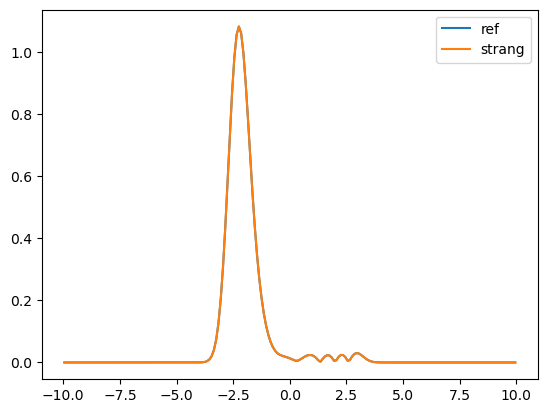

The L2 error in Strang splitting is tensor([1.6601e-05], dtype=torch.float64)


In [26]:
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
    return u

T = 1

urefT = exact(T, u)
ustrangT = runstrang(T,1000,u)
ex.plot(plt, x, abs(urefT))
ex.plot(plt, x, abs(ustrangT))
plt.legend(['ref','strang'])
plt.show()

print(f'The L2 error in Strang splitting is {ex.l2norm(urefT-ustrangT, xr)}')

When we run Strang splitting with a small enough time step, it becomes pretty accurate

### Analysing order of Strang

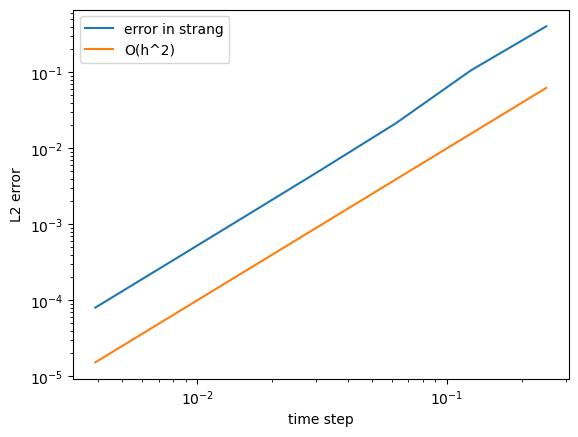

In [27]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist
err = [ex.l2norm(urefT-runstrang(T,N,u))[0] for N in Nlist]
plt.loglog(hlist, err)
plt.loglog(hlist, hlist**2)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in strang', 'O(h^2)'])
plt.show()

As we can see, the (global) error of Strang is $\mathcal{O}(h^2)$.

### A comparison of speed

When $n$ becomes large, `matrix_exp` is an extremely inefficient method since its cost scales as $\mathcal{O}\left(n^3\right)$. On the other hand, the cost of Strang scales as $\mathcal{O}\left(n \log n\right)$, which is significantly cheaper

In [28]:
n = 2000

L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)    


V = x**4 - 10*x**2

T = 1

tic_exact = time.perf_counter()
D2 = ex.diffmatrix(2, n, xr)
H = -D2 + es.linalg.diag(V)
urefT = es.linalg.matmul(matrix_exp(-1j*T*H) , u)
toc_exact = time.perf_counter()
print(f'matrix_exp took {toc_exact-tic_exact:0.4f} seconds')

tic_strang = time.perf_counter()
eLu = lambda h, u: ex.diffopexp(0, 2, 1j*h, u, xr)
eVu = lambda h, u: exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
    return u

ustrangT = runstrang(T, 1000, u)
toc_strang = time.perf_counter()


print(f'Strang took {toc_strang-tic_strang:0.4f} seconds')

print(f'The L2 error in Strang splitting is {ex.l2norm(urefT-ustrangT, xr)}')

matrix_exp took 9.6509 seconds
Strang took 0.6321 seconds
The L2 error in Strang splitting is tensor([1.6571e-05], dtype=torch.float64)


We achieve pretty reasonable accuracy at a much lower cost when using Strang splitting.

### Observables again

Recall that observables are implemented using the `observable` function, the syntax of which is:

```Python
    ex.observable(obs, u, xrange)
```
where `u` is the vector of values on a periodic grid defined on the domain `xrange`, and `obs` is a Hermitian operator or matrix. In the first instance, we used `obs` as Hermitian matrices. However, this is not fully efficient. For example passing the $n \times n$ Hamiltonian matrix will involve a cost of $\mathcal{O}\left(n^2\right)$ in the computation of the observable. Instead, if we use the operator form, the cost is $\mathcal{O}\left(n \log n\right)$ due to the use of FFTs. Let's see this with examples:

We create the Hamiltonian operator as a lambda function:

In [29]:
Hop = lambda psi: -ex.diffop(0, 2, psi, xr) + V*psi

Then, the energy observable can be defined as:

In [30]:
energy = lambda f: ex.observable(Hop, f, xr)

i.e. we use Hop instead of H! 

Similarly, we create other operators. For instance, the position operator is multiplication by $x$ which is achieved as `lambda psi: x*psi` and the momentum operator is multiplication by $-i$ and 1st derivative operation. Let us put these in a dictionary:

In [31]:
obs = {'energy': Hop, 
'position': lambda psi: x*psi,
'momentum': lambda psi: 1j*ex.diffop(0, 1, psi, xr),
'kinetic': lambda psi: -ex.diffop(0, 2, psi, xr),
'potential':lambda psi: V*psi}

We will store the values of observables in the dictionary `obsvalues`. Let us set all values to `[]`

In [32]:
obsvalues = {}
for o in obs:
    obsvalues[o]=[]

def compute_obs_values(u):
    for o in obs:
        op = obs[o]
        obsvalues[o].append(ex.observable(op, u, xr)[0])    # not the most general for batch parallelized

In [33]:
n = 100
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)    

V = x**4 - 10*x**2

T = 1

compute_obs_values(u)


eLu = lambda h, u: ex.diffopexp(0, 2, 1j*h, u, xr)
eVu = lambda h, u: exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
        compute_obs_values(u)
    return u

ustrangT = runstrang(T, 1000, u)

In [34]:
time_grid = torch.arange(1000+1)/1000

Total energy does change now! Strang does not conserve energy exactly.

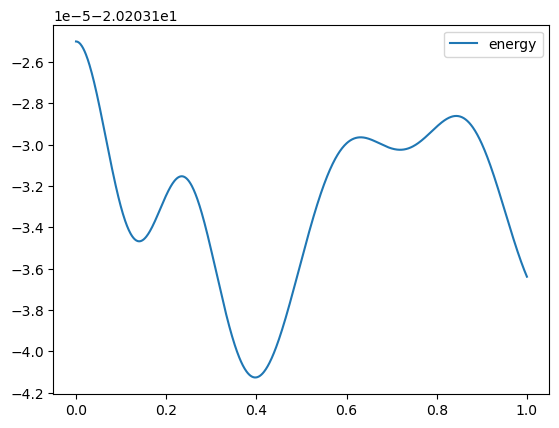

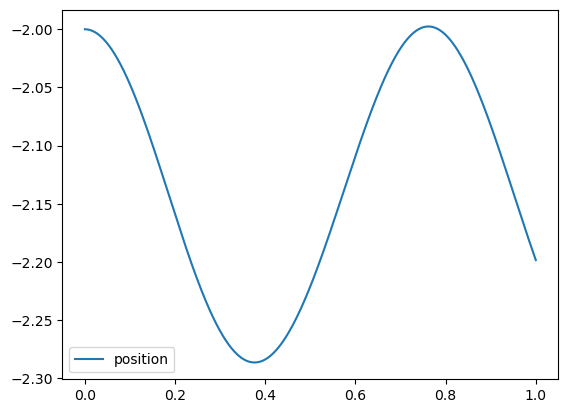

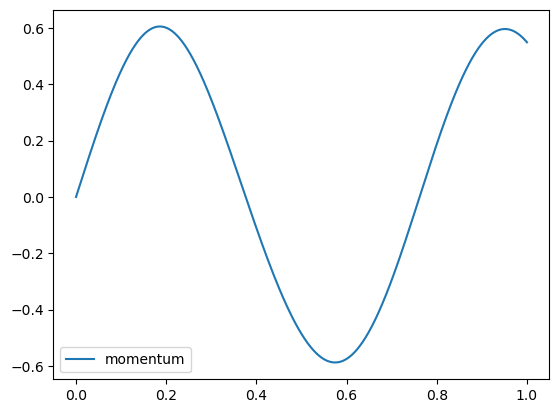

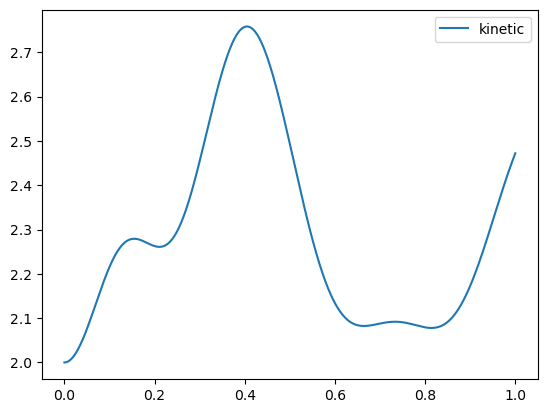

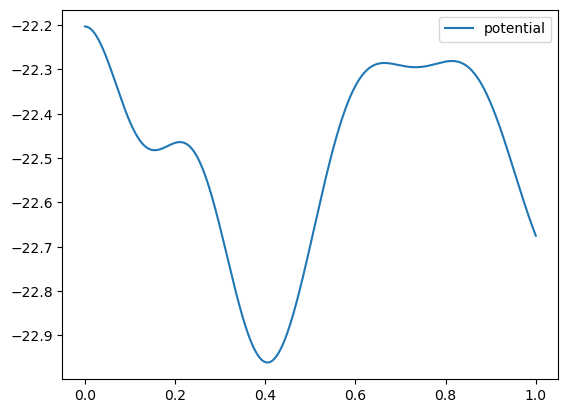

In [38]:
for o in obs:
    ov = obsvalues[o]
    plt.figure()
    plt.plot(time_grid, ov)   
    plt.legend([o])
    plt.show()

### No need for `lambda`

Of course, there is no need to use `lambda` functions `eVu`, `eLu` and `strang`. We can directly compute the actions of `exp(V)` and `exp(D2)` in the loop of `runstrang`.

In [35]:
obsvalues = {}
for x in obs:
    obsvalues[x]=[]

n = 100
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)    

V = x**4 - 10*x**2

T = 1

compute_obs_values(u)

def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = exp(-1j*(h/2)*V)*u
        u = ex.diffopexp(0, 2, 1j*h, u, xr)
        u = exp(-1j*(h/2)*V)*u
        compute_obs_values(u)
    return u

ustrangT = runstrang(T, 1000, u)